## Experiment to predict citation relationship between two article nodes based on node embeddings (30_30)

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Step 1: Load node embeddings
embeddings = {}
node_ids = []
with open("walks-vec-30.txt", "r") as f:
    for line in f:
        line = line.strip().split()
        node_id = line[0]
        node_ids.append(node_id)
        embedding = np.array(line[1:], dtype=np.float32)
        embeddings[node_id] = embedding

In [3]:
node_ids

['v1031',
 'v1055',
 'v1000',
 'v1284',
 'i165395',
 'i247408',
 'i238082',
 'i76913',
 'i250913',
 'i226929',
 'i200018',
 'i133521',
 'i154989',
 'i209007',
 'i9527',
 'i149918',
 'i202638',
 'i95206',
 'i138664',
 'i138229',
 'i116314',
 'i63564',
 'i157480',
 'i216876',
 'i77065',
 'i122188',
 'i139558',
 'i238189',
 'i42745',
 'i38075',
 'i9249',
 'i95398',
 'i26640',
 'i59794',
 'i190945',
 'i63904',
 'i178903',
 'i81697',
 'i116446',
 'i148513',
 'i107571',
 'i241977',
 'i216944',
 'i116340',
 'i133990',
 'i23635',
 'i169607',
 'i26139',
 'i122084',
 'i64046',
 'i204688',
 'i32308',
 'i20725',
 'i186937',
 'i35222',
 'i95109',
 'i3964',
 'i49765',
 'i133689',
 'i133462',
 'i121725',
 'i42441',
 'i187155',
 'i9566',
 'i169583',
 'i193911',
 'i9008',
 'i105535',
 'i35115',
 'i221306',
 'i66722',
 'i233792',
 'i42426',
 'i234221',
 'i65877',
 'i217487',
 'i56913',
 'i64439',
 'i113856',
 'i138791',
 'i155157',
 'i149649',
 'i182631',
 'i51194',
 'i57633',
 'i121728',
 'i121911',
 '

In [4]:
embeddings

{'v1031': array([-0.462649,  0.651549, -0.043362,  0.13138 , -0.002182, -0.401854,
        -0.255589,  0.800597, -0.258967, -1.354312, -0.946155, -1.470167,
        -0.567138, -0.068272,  0.054502,  0.105712, -0.695442,  0.942758,
        -1.068004,  0.649646, -0.033202,  0.843987,  0.35039 ,  0.663421,
        -0.141045,  1.134575,  0.244918,  0.905062,  0.465766, -0.845586,
        -0.432562, -1.206319, -0.463072, -0.541642,  0.570497, -0.261728,
         0.756486,  0.645055,  0.530765, -0.093087,  0.462092,  1.132533,
        -0.901753, -0.253736,  0.112386,  0.49083 ,  0.344003, -0.236037,
        -0.558706, -0.310409,  0.607637,  0.051975,  0.227589,  0.721179,
        -0.275517, -0.995298, -0.495593,  0.555857,  1.853209,  0.050229,
         1.637716, -1.387154, -0.797489,  0.086056, -0.893624,  0.658726,
        -0.907549, -0.887336,  0.546929,  0.091046, -0.041107, -0.62214 ,
        -0.174088, -1.290693,  0.238017,  0.038595,  1.205024,  0.189018,
         0.333962, -1.426343,

In [5]:
from py2neo import Graph
import pandas as pd
from numpy.random import randint

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql.types import *
from pyspark.sql import functions as F

from sklearn.metrics import roc_curve, auc
from collections import Counter

from cycler import cycler
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [6]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", ""))

##### Cypher query to extract article node pairs that have CITED relationship between them and giving them a true (1) label

In [7]:
train_existing_links = graph.run("""
MATCH (a1:Article)-[:CITED]->(a2:Article)
RETURN id(a1) AS node1, id(a2) AS node2, 1 AS label
""").to_data_frame()

In [8]:
len(train_existing_links)

289908

##### Cypher query to extract article node pairs that are related but are not directly connected through a CITED relationship but have an article in common between them, and giving them a false(0) label

In [9]:
train_missing_links = graph.run("""MATCH (a1:Article)-[:CITED]-(a2:Article)
WHERE NOT ((a1)-[:CITED]->(a2))
RETURN id(a1) AS node1, id(a2) AS node2, 0 AS label
""").to_data_frame()

In [10]:
len(train_missing_links)

289412

In [11]:
train_existing_links

node1   node2  label
0            0    1009      1
1            0    1008      1
2            0    1007      1
3            0    1006      1
4            0    1005      1
...        ...     ...    ...
289903  262739  264601      1
289904  262739  249680      1
289905  262739   54197      1
289906  262739  264604      1
289907  262739  264275      1

[289908 rows x 3 columns]

In [12]:
train_missing_links

node1   node2  label
0            8  167055      0
1           18  133977      0
2           18   70335      0
3           22  116496      0
4           27   63702      0
...        ...     ...    ...
289407  264611  262739      0
289408  264612  262739      0
289409  264613  262739      0
289410  264614  262739      0
289411  264615  262739      0

[289412 rows x 3 columns]

In [13]:
train_missing_links = train_missing_links.drop_duplicates()

In [14]:
len(train_missing_links)

289412

In [15]:
import pandas as pd

combined_links = pd.concat([train_existing_links, train_missing_links], ignore_index = True)

combined_links.drop_duplicates(subset=['node1', 'node2'], inplace = True)

combined_links.reset_index(drop=True, inplace=True)

In [16]:
len(combined_links)

579320

In [17]:
embeddings

{'v1031': array([-0.462649,  0.651549, -0.043362,  0.13138 , -0.002182, -0.401854,
        -0.255589,  0.800597, -0.258967, -1.354312, -0.946155, -1.470167,
        -0.567138, -0.068272,  0.054502,  0.105712, -0.695442,  0.942758,
        -1.068004,  0.649646, -0.033202,  0.843987,  0.35039 ,  0.663421,
        -0.141045,  1.134575,  0.244918,  0.905062,  0.465766, -0.845586,
        -0.432562, -1.206319, -0.463072, -0.541642,  0.570497, -0.261728,
         0.756486,  0.645055,  0.530765, -0.093087,  0.462092,  1.132533,
        -0.901753, -0.253736,  0.112386,  0.49083 ,  0.344003, -0.236037,
        -0.558706, -0.310409,  0.607637,  0.051975,  0.227589,  0.721179,
        -0.275517, -0.995298, -0.495593,  0.555857,  1.853209,  0.050229,
         1.637716, -1.387154, -0.797489,  0.086056, -0.893624,  0.658726,
        -0.907549, -0.887336,  0.546929,  0.091046, -0.041107, -0.62214 ,
        -0.174088, -1.290693,  0.238017,  0.038595,  1.205024,  0.189018,
         0.333962, -1.426343,

In [18]:
new_embeddings = {key[1:]: value for key, value in embeddings.items()}
new_embeddings

{'1031': array([-0.462649,  0.651549, -0.043362,  0.13138 , -0.002182, -0.401854,
        -0.255589,  0.800597, -0.258967, -1.354312, -0.946155, -1.470167,
        -0.567138, -0.068272,  0.054502,  0.105712, -0.695442,  0.942758,
        -1.068004,  0.649646, -0.033202,  0.843987,  0.35039 ,  0.663421,
        -0.141045,  1.134575,  0.244918,  0.905062,  0.465766, -0.845586,
        -0.432562, -1.206319, -0.463072, -0.541642,  0.570497, -0.261728,
         0.756486,  0.645055,  0.530765, -0.093087,  0.462092,  1.132533,
        -0.901753, -0.253736,  0.112386,  0.49083 ,  0.344003, -0.236037,
        -0.558706, -0.310409,  0.607637,  0.051975,  0.227589,  0.721179,
        -0.275517, -0.995298, -0.495593,  0.555857,  1.853209,  0.050229,
         1.637716, -1.387154, -0.797489,  0.086056, -0.893624,  0.658726,
        -0.907549, -0.887336,  0.546929,  0.091046, -0.041107, -0.62214 ,
        -0.174088, -1.290693,  0.238017,  0.038595,  1.205024,  0.189018,
         0.333962, -1.426343, 

In [19]:
new_node_ids = [node_id[1:] for node_id in node_ids]
new_node_ids

['1031',
 '1055',
 '1000',
 '1284',
 '165395',
 '247408',
 '238082',
 '76913',
 '250913',
 '226929',
 '200018',
 '133521',
 '154989',
 '209007',
 '9527',
 '149918',
 '202638',
 '95206',
 '138664',
 '138229',
 '116314',
 '63564',
 '157480',
 '216876',
 '77065',
 '122188',
 '139558',
 '238189',
 '42745',
 '38075',
 '9249',
 '95398',
 '26640',
 '59794',
 '190945',
 '63904',
 '178903',
 '81697',
 '116446',
 '148513',
 '107571',
 '241977',
 '216944',
 '116340',
 '133990',
 '23635',
 '169607',
 '26139',
 '122084',
 '64046',
 '204688',
 '32308',
 '20725',
 '186937',
 '35222',
 '95109',
 '3964',
 '49765',
 '133689',
 '133462',
 '121725',
 '42441',
 '187155',
 '9566',
 '169583',
 '193911',
 '9008',
 '105535',
 '35115',
 '221306',
 '66722',
 '233792',
 '42426',
 '234221',
 '65877',
 '217487',
 '56913',
 '64439',
 '113856',
 '138791',
 '155157',
 '149649',
 '182631',
 '51194',
 '57633',
 '121728',
 '121911',
 '17980',
 '71744',
 '234310',
 '111327',
 '23475',
 '42781',
 '230964',
 '143952',
 '165

In [20]:
import numpy as np

# List to store the extracted embeddings
node_con_embeddings = []
labels = []
linkCount = 0
listNoLinkCount = 0
noLinkCount = 0
# Iterate over the rows of the combined_existing_links DataFrame
for index, row in train_existing_links.iterrows():
    node1_id = str(row['node1'])
    node2_id = str(row['node2'])
    label = row['label']
    
    # Check if the node IDs exist in the embeddings dictionary
    if node1_id in new_node_ids and node2_id in new_node_ids and label == 1:
        node1_embedding = new_embeddings[node1_id]
        node2_embedding = new_embeddings[node2_id]
        
        # Append the embeddings to the node_embeddings list
        node_con_embeddings.append(np.concatenate((node1_embedding, node2_embedding)))
        labels.append(label)
        linkCount = linkCount + 1               

# Convert the node_embeddings list to a numpy array
node_con_embeddings = np.array(node_con_embeddings)
labels = np.array(labels)
print(linkCount)

289870


#### The above code implies that we have 289870 node embeddings that represent connected nodes (label = 1)

In [21]:
train_missing_links

node1   node2  label
0            8  167055      0
1           18  133977      0
2           18   70335      0
3           22  116496      0
4           27   63702      0
...        ...     ...    ...
289407  264611  262739      0
289408  264612  262739      0
289409  264613  262739      0
289410  264614  262739      0
289411  264615  262739      0

[289412 rows x 3 columns]

In [22]:
len(train_missing_links)

289412

In [23]:
import numpy as np

# List to store the extracted embeddings
node_negative_embeddings = []
labels_negative = []
noLinkCount = 0
# Iterate over the rows of the combined_existing_links DataFrame
for index, row in train_missing_links.iterrows():
    node1_id = str(row['node1'])
    node2_id = str(row['node2'])
    label = row['label']
    
    # Check if the node IDs exist in the embeddings dictionary
    if node1_id in new_node_ids and node2_id in new_node_ids and label == 0:
        node1_embedding = new_embeddings[node1_id]
        node2_embedding = new_embeddings[node2_id]
        # Append the embeddings to the node_embeddings list
        node_negative_embeddings.append(np.concatenate((node1_embedding, node2_embedding)))
        labels_negative.append(label)
        noLinkCount = noLinkCount + 1                

# Convert the node_embeddings list to a numpy array
node_negative_embeddings = np.array(node_negative_embeddings)
labels_negative = np.array(labels_negative)
print(noLinkCount)

289374


In [24]:
len(labels_negative)

289374

In [25]:
len(labels_negative)

289374

In [26]:
# Convert the labels list to a numpy array
labels_negative = np.array(labels_negative)

# Reshape the labels array to a 2D array with shape (n_samples, 1)
labels_negative = labels_negative.reshape(-1, 1)

# Concatenate the embeddings and labels along the second axis
data = np.concatenate((node_negative_embeddings, labels_negative), axis=1)

# Shuffle the data
np.random.shuffle(data)

# Split the shuffled data back into embeddings and labels
node_negative_embeddings_shuffled = data[:, :-1]
labels_negative_shuffled = data[:, -1]

# Convert the shuffled arrays back to numpy arrays
node_negative_embeddings_shuffled = np.array(node_negative_embeddings_shuffled)
labels_negative_shuffled = np.array(labels_negative_shuffled)


In [27]:
len(node_negative_embeddings_shuffled)

289374

The above code indicates that we have 263886 node embeddings which have no links between them (label=0)

In [28]:
print(len(node_con_embeddings))
print(len(labels))
print(len(node_negative_embeddings_shuffled))
print(len(labels_negative_shuffled))

289870
289870
289374
289374


In [29]:
# Convert node_negative_embeddings to a numpy array
node_negative_embeddings = np.array(node_negative_embeddings)

In [30]:
# Combine the positive and negative samples
balanced_node_embeddings = np.concatenate((node_negative_embeddings, node_con_embeddings), axis=0)

In [31]:
len(balanced_node_embeddings)

579244

In [32]:
balanced_labels = np.concatenate((labels_negative_shuffled, labels), axis = 0)

In [33]:
len(balanced_labels)

579244

In [34]:
# Shuffle the data while maintaining correspondence
permutation = np.random.permutation(len(balanced_node_embeddings))
balanced_node_embeddings = balanced_node_embeddings[permutation]
balanced_labels = balanced_labels[permutation]

In [35]:
len(balanced_node_embeddings)

579244

### Model Training

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(balanced_node_embeddings, balanced_labels, test_size=0.2, random_state=42)

In [38]:
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 463395
Testing set size: 115849


In [39]:
model = LogisticRegression(solver='liblinear')

In [40]:
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [41]:
predictions = model.predict(X_test)

In [42]:
# Predict the probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

In [43]:
# Predict the labels for the test data
y_pred = model.predict(X_test)

In [44]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


In [45]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

In [46]:
# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.8630199656449343
Precision: 0.862382176520994
Recall: 0.8652143262435736
F1 Score: 0.86379592992816
ROC AUC Score: 0.8630110459437663


Accuracy: 0.8630199656449343
Precision: 0.862382176520994
Recall: 0.8652143262435736
F1 Score: 0.86379592992816
ROC AUC Score: 0.8630110459437663


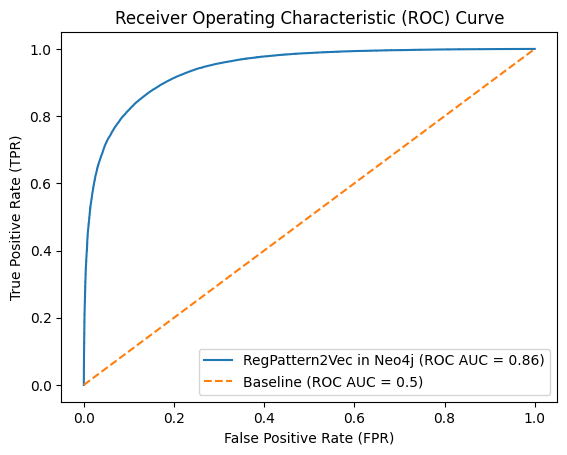

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(balanced_node_embeddings, balanced_labels, test_size=0.2, random_state=42)

model = LogisticRegression(solver='liblinear')

model.fit(X_train, y_train)

# Predict the probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Predict the labels for the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate baseline FPR and TPR
baseline_fpr = np.linspace(0, 1, 100)
baseline_tpr = baseline_fpr  # TPR = FPR for the baseline curve

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
plt.plot(fpr, tpr, label='RegPattern2Vec in Neo4j (ROC AUC = {:.2f})'.format(roc_auc))
plt.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Baseline (ROC AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [48]:
node_ids = ['100', '102']
node1_id, node2_id = node_ids[0], node_ids[1]

node1_embedding_run = new_embeddings[node1_id]
node2_embedding_run = new_embeddings[node2_id]

In [49]:
node_embeddings = np.concatenate([node1_embedding_run, node2_embedding_run])
node_embeddings = node_embeddings.reshape(1,-1)
prediction = model.predict(node_embeddings)

# Interpret the prediction
if prediction == 1:
    print("A citation relationship is predicted between the two nodes.")
else:
    print("No citation relationship is predicted between the two nodes.")

A citation relationship is predicted between the two nodes.
